# Object tracking using Bayesian Tracker

This notebook shows how to previously localised and classified objects from a series of mask images and unite them over time using Bayesian multi-object tracking (btrack). 

The sections of this notebook are as follows:

1. Load segmentation objects and filter based on size
2. Run btrack, uniting the objects locations over time
3. Batch process

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

In [1]:
import btrack
from tqdm.auto import tqdm
import os
import glob

## 1. Load segmentation objects

In [29]:
expt = 'ND0017'
pos = 'Pos7'
root_dir = '/home/nathan/data/kraken/ras/'

In [30]:
with btrack.dataio.HDF5FileHandler(
     f'{root_dir}/{expt}/{pos}/objects.h5', 'r', obj_type='obj_type_1',
) as hdf:
    objects_gfp = hdf.objects
with btrack.dataio.HDF5FileHandler(
     f'{root_dir}/{expt}/{pos}/objects.h5', 'r', obj_type='obj_type_2',
) as hdf:
    objects_rfp = hdf.objects

Check objects feature classification

In [31]:
objects_gfp[0]

,ID,x,y,z,t,dummy,states,label,prob,area,class id,eccentricity,mean_intensity,prob_anaphase,prob_apoptosis,prob_interphase,prob_metaphase,prob_prometaphase
0,0,49.476803,14.483279,0.0,0,False,0,0,0.0,1026.0,1.0,0.82399,47.17601,2.381370e-11,5.544584e-08,0.999997,2.161737e-12,0.000003


In [32]:
objects_rfp[0]

,ID,x,y,z,t,dummy,states,label,prob,area,class id,eccentricity,mean_intensity,prob_anaphase,prob_apoptosis,prob_interphase,prob_metaphase,prob_prometaphase
0,0,1156.480469,531.609375,0.0,0,False,0,0,0.0,1073.0,2.0,0.700443,14.078041,2.373290e-07,0.000402,0.999581,4.701943e-07,0.000016


# Checking dist of classes

In [6]:
import pandas as pd

In [7]:
objects = objects_gfp+objects_rfp
labels = []
for i in range(len(objects)):
    labels.append(objects[i].label)
df = pd.DataFrame(labels)

In [8]:
import seaborn as sb
%matplotlib inline

<AxesSubplot:ylabel='Count'>

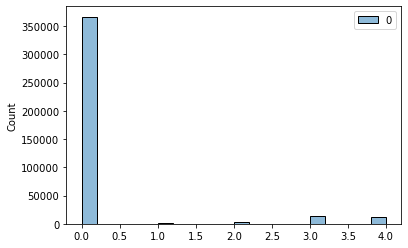

In [9]:
### 
sb.histplot(df)

## 2. Run btrack  

Unite each object with it's subsequent position at the following time point and export as a tracking file. Note that you may need different btrack configurations for different populations.

#### For GFP objects

In [15]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '../models/MDCK_config_wildtype.json'
    )
    tracker.max_search_radius = 40

    # append the objects to be tracked
    tracker.append(objects_gfp)

    # set the volume
    tracker.volume=((0, 1600), (0, 1200), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'{root_dir}/{expt}/{pos}/tracks.h5', obj_type='obj_type_1')

    # get the tracks in a format for napari visualization (optional)
    visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    gfp_tracks = tracker.tracks

[INFO][2022/05/19 12:01:43 PM] btrack (v0.4.3) library imported
[INFO][2022/05/19 12:01:43 PM] Setting max XYZ search radius to: 100
[INFO][2022/05/19 12:01:43 PM] Starting BayesianTracker session
[INFO][2022/05/19 12:01:43 PM] Loading motion model: MDCK_motion
[INFO][2022/05/19 12:01:43 PM] Setting max XYZ search radius to: 40
[INFO][2022/05/19 12:01:48 PM] Set volume to ((0, 1600), (0, 1200), (-100000.0, 100000.0))
[INFO][2022/05/19 12:01:48 PM] Starting tracking... 
[INFO][2022/05/19 12:01:49 PM] Tracking objects in frames 0 to 99 (of 1325)...
[INFO][2022/05/19 12:01:50 PM] Tracking objects in frames 100 to 199 (of 1325)...
[INFO][2022/05/19 12:01:52 PM] Tracking objects in frames 200 to 299 (of 1325)...
[INFO][2022/05/19 12:01:53 PM] Tracking objects in frames 300 to 399 (of 1325)...
[INFO][2022/05/19 12:01:55 PM] Tracking objects in frames 400 to 499 (of 1325)...
[INFO][2022/05/19 12:01:58 PM] Tracking objects in frames 500 to 599 (of 1325)...
[INFO][2022/05/19 12:02:03 PM] Tracki

#### For RFP objects

In [13]:
objects_rfp[0]

,ID,x,y,z,t,dummy,states,label,prob,area,class id,eccentricity,mean_intensity,prob_anaphase,prob_apoptosis,prob_interphase,prob_metaphase,prob_prometaphase
0,0,1156.480469,531.609375,0.0,0,False,0,0,0.0,1073.0,2.0,0.700443,14.078041,2.373290e-07,0.000402,0.999581,4.701943e-07,0.000016


In [33]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '../models/MDCK_config_scribble_sparse.json'
    )
    tracker.max_search_radius = 10

    # append the objects to be tracked
    tracker.append(objects_rfp)

    # set the volume
    tracker.volume=((0, 1600), (0, 1200), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'{root_dir}/{expt}/{pos}/tracks.h5', obj_type='obj_type_2')

    # get the tracks in a format for napari visualization (optional)
    visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    rfp_tracks = tracker.tracks

[INFO][2022/05/19 12:20:18 PM] btrack (v0.4.3) library imported
[INFO][2022/05/19 12:20:18 PM] Setting max XYZ search radius to: 100
[INFO][2022/05/19 12:20:18 PM] Starting BayesianTracker session
[INFO][2022/05/19 12:20:18 PM] Loading motion model: MDCK_motion
[INFO][2022/05/19 12:20:18 PM] Setting max XYZ search radius to: 10
[INFO][2022/05/19 12:20:18 PM] Set volume to ((0, 1600), (0, 1200), (-100000.0, 100000.0))
[INFO][2022/05/19 12:20:18 PM] Starting tracking... 
[INFO][2022/05/19 12:20:18 PM] Tracking objects in frames 0 to 99 (of 1325)...
[INFO][2022/05/19 12:20:18 PM] Tracking objects in frames 100 to 199 (of 1325)...
[INFO][2022/05/19 12:20:18 PM] Tracking objects in frames 200 to 299 (of 1325)...
[INFO][2022/05/19 12:20:18 PM] Tracking objects in frames 300 to 399 (of 1325)...
[INFO][2022/05/19 12:20:18 PM] Tracking objects in frames 400 to 499 (of 1325)...
[INFO][2022/05/19 12:20:18 PM] Tracking objects in frames 500 to 599 (of 1325)...
[INFO][2022/05/19 12:20:18 PM] Tracki

# 6. Batch process
Iterate over many experiments and positions (need to ensure you define normalisation and classification functions above first)

In [2]:
import pandas as pd

In [3]:
expt_info = pd.read_csv('/home/nathan/data/kraken/ras/experiment_info_april22.csv')
del expt_info['Unnamed: 0']
expt_pos_list = expt_info.loc[(expt_info['Usable?'] == True) & 
                              (expt_info['Condition'] == "99:1 wt:ras+" )]

In [4]:
expt_pos_list

,Experiments,Positions,Condition,Position notes,Experiment Notes,Usable?
178,ND0014,Pos5,99:1 wt:ras+,induced,NaN,True
179,ND0014,Pos6,99:1 wt:ras+,induced 2x seed dens,NaN,True
180,ND0014,Pos7,99:1 wt:ras+,induced 2x seed dens,NaN,True
181,ND0014,Pos8,99:1 wt:ras+,induced 2x seed dens,NaN,True
182,ND0014,Pos9,99:1 wt:ras+,induced 2x seed dens,NaN,True
208,ND0016,Pos7,99:1 wt:ras+,induced 2x seed dens,NaN,True
209,ND0016,Pos8,99:1 wt:ras+,induced 2x seed dens,NaN,True
211,ND0016,Pos10,99:1 wt:ras+,induced 3x seed dens,NaN,True
212,ND0016,Pos11,99:1 wt:ras+,induced 3x seed dens,NaN,True
213,ND0016,Pos12,99:1 wt:ras+,induced 3x seed dens,NaN,True


In [ ]:
root_dir = '/home/nathan/data/kraken/ras'
# expt_list = ['ND0009', 'ND0010', 'ND0011']
# pos_list = 'all'
# overwrite = False

# for expt in expt_list:
    
#         # Find all positions in that experiment, if pos_list is all then it finds all positions
#         if pos_list == 'all':
#             pos_list = [pos for pos in os.listdir(f'{root_dir}/{expt}') 
#                     if 'Pos' in pos 
#                     and os.path.isdir(f'{root_dir}/{expt}/{pos}')]  
            
#         ### Iterate over all positions in that experiment
#         for pos in pos_list:
            
for i, expt_pos in tqdm(expt_pos_list.iterrows(), desc = 'Progress of experiment annotation', total = len(expt_pos_list)):    
    expt = expt_pos['Experiments']
    pos = expt_pos['Positions']
#         ### check if overwrite param is false check if raw directory already created and if type of transform file already exists and decide whether to skip pos
#         if not overwrite and glob.glob(f'{root_dir}/{expt}/{pos}/*tracks*.h5'):
#             print(glob.glob(f'{root_dir}/{expt}/{pos}/*tracks*.h5'), f'file found, skipping {expt}/{pos}')
#             continue
    if os.path.exists(f'{root_dir}/{expt}/{pos}/tracks.h5'):
        continue
    print(f'Starting {expt}/{pos}')
    # load gfp objects
    with btrack.dataio.HDF5FileHandler(
         f'{root_dir}/{expt}/{pos}/objects.h5', 'r', obj_type='obj_type_1',
    ) as hdf:
        objects_gfp = hdf.objects
    # load rfp objects
    with btrack.dataio.HDF5FileHandler(
         f'{root_dir}/{expt}/{pos}/objects.h5', 'r', obj_type='obj_type_2',
    ) as hdf:
        objects_rfp = hdf.objects

    # initialise a tracker session using a context manager for gfp
    with btrack.BayesianTracker() as tracker:

        # configure the tracker using a config file
        tracker.configure_from_file(
            '../models/MDCK_config_wildtype.json'
        )
        tracker.max_search_radius = 40

        # append the objects to be tracked
        tracker.append(objects_gfp)

        # set the volume
        tracker.volume=((0, 1600), (0, 1200), (-1e5, 1e5))

        # track them (in interactive mode)
        tracker.track_interactive(step_size=100)

        # generate hypotheses and run the global optimizer
        tracker.optimize()

        tracker.export(f'{root_dir}/{expt}/{pos}/tracks.h5', obj_type='obj_type_1')

    # initialise a tracker session using a context manager for rfp
    with btrack.BayesianTracker() as tracker:

        # configure the tracker using a config file
        tracker.configure_from_file(
            '../models/MDCK_config_scribble_sparse.json'
        )
        tracker.max_search_radius = 40

        # append the objects to be tracked
        tracker.append(objects_rfp)

        # set the volume
        tracker.volume=((0, 1600), (0, 1200), (-1e5, 1e5))

        # track them (in interactive mode)
        tracker.track_interactive(step_size=100)

        # generate hypotheses and run the global optimizer
        tracker.optimize()

        tracker.export(f'{root_dir}/{expt}/{pos}/tracks.h5', obj_type='obj_type_2')

    print(f'Finished {expt}/{pos}')

Progress of experiment annotation:   0%|          | 0/51 [00:00<?, ?it/s]

Starting ND0016/Pos7


[INFO][2022/05/20 08:14:26 AM] btrack (v0.4.3) library imported
[INFO][2022/05/20 08:14:26 AM] Setting max XYZ search radius to: 100
[INFO][2022/05/20 08:14:26 AM] Starting BayesianTracker session
[INFO][2022/05/20 08:14:26 AM] Loading motion model: MDCK_motion
[INFO][2022/05/20 08:14:26 AM] Setting max XYZ search radius to: 40
[INFO][2022/05/20 08:14:28 AM] Set volume to ((0, 1600), (0, 1200), (-100000.0, 100000.0))
[INFO][2022/05/20 08:14:28 AM] Starting tracking... 
[INFO][2022/05/20 08:14:29 AM] Tracking objects in frames 0 to 99 (of 3457)...
[INFO][2022/05/20 08:14:29 AM] Tracking objects in frames 100 to 199 (of 3457)...
[INFO][2022/05/20 08:14:29 AM] Tracking objects in frames 200 to 299 (of 3457)...
[INFO][2022/05/20 08:14:29 AM] Tracking objects in frames 300 to 399 (of 3457)...
[INFO][2022/05/20 08:14:29 AM] Tracking objects in frames 400 to 499 (of 3457)...
[INFO][2022/05/20 08:14:30 AM] Tracking objects in frames 500 to 599 (of 3457)...
[INFO][2022/05/20 08:14:30 AM] Tracki